In [67]:
# !pip install -U spacy
# !python3 -m spacy download en_core_web_sm
# ! pip install wordcloud

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [99]:
# core libraries
import re
import time
import string
from glob import iglob

# data handling and machine learning
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer

# text processing
import spacy
#nlp = spacy.load('en_core_web_sm')
import en_core_web_sm
nlp = en_core_web_sm.load()

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
en_stopwords = stopwords.words('english')  # might have to use 'en' instead of 'english'
stopwords = set(en_stopwords + ['rt'])  # add RT to stopwords (retweet)

# plotting
import matplotlib.pyplot as plt
%matplotlib inline

from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
import os
os.getcwd()

'/home/ec2-user/SageMaker'

In [5]:
raw_data = pd.read_csv('/home/ec2-user/SageMaker/df_location_master_final.csv', sep = ',' , parse_dates=True)  

In [6]:
raw_data.columns=raw_data.columns.str.replace(' ', '_')
raw_data.columns=map(str.lower, raw_data.columns)
print(raw_data.columns)

Index(['unnamed:_0', 'business_id', 'business_name', 'business_address',
       'business_city', 'business_state', 'business_postal_code',
       'business_latitude', 'business_longitude', 'neighborhood',
       'inspection_id', 'inspection_date', 'inspection_score',
       'inspection_type', 'violation_id', 'violation_description',
       'risk_category'],
      dtype='object')


In [11]:
df_corpus=raw_data[['business_id','inspection_date', 'violation_description']]
df_corpus['inspection_date']= pd.to_datetime(df_corpus['inspection_date'])

df_corpus['violation_description'] = df_corpus['violation_description'].fillna('noviolation')

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [12]:
df_corpus.head(5)
# Do I add No violation as a text? I have done both ways and decided to do noviolation a single word. This way i will get the benefit of having it without the effect of seperate No .exactly what I wanted and feel works th ebest this way
# So I need to addNoViolation to Nans. I did!!!

,business_id,inspection_date,violation_description
0,852,2017-11-29,Improper food storage
1,852,2017-11-29,Permit license or inspection report not posted
2,852,2017-11-29,Unapproved or unmaintained equipment or utensils
3,852,2017-12-07,noviolation
4,852,2017-11-29,Wiping cloths not clean or properly stored or ...


In [9]:
df_corpus['violation_description']= df_corpus['violation_description'].to_string()

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [13]:
df_corpus.head()
# Because of the clenaing efforts of step 1 and 3 I did not need to use and regex here.

,business_id,inspection_date,violation_description
0,852,2017-11-29,Improper food storage
1,852,2017-11-29,Permit license or inspection report not posted
2,852,2017-11-29,Unapproved or unmaintained equipment or utensils
3,852,2017-12-07,noviolation
4,852,2017-11-29,Wiping cloths not clean or properly stored or ...


In [14]:
# simple clean text function -- spacy lowercases, removes stopwords, lemmatizes
def clean_text(docs):
    # remove punctuation and numbers
    # I do this before lemmatizing, so things like "act's" turn into 'act' instead of 'act s'
    print('removing punctuation')
    table = str.maketrans({key: None for key in string.punctuation + string.digits})
    clean_docs = [d.translate(table) for d in docs]
    
    print('spacy nlp...')
    nlp_docs = [nlp(d) for d in clean_docs]
    
    # keep the word if it's a pronoun, otherwise use the lemma
    # otherwise spacy substitutes '-PRON-' for pronouns
    print('getting lemmas')
    lemmatized_docs = [[w.lemma_ if w.lemma_ != '-PRON-'
                           else w.lower_
                           for w in d]
                      for d in nlp_docs]
    
    # remove stopwords
    print('removing stopwords')
    lemmatized_docs = [[lemma for lemma in doc if lemma not in stopwords] for doc in lemmatized_docs]
    
    # join tokens back into doc
    clean_docs = [' '.join(l) for l in lemmatized_docs]
        
    return clean_docs

In [15]:
just_violation = df_corpus['violation_description']
clean_texts = clean_text(just_violation)

removing punctuation
spacy nlp...
getting lemmas
removing stopwords


In [16]:
df_corpus['violation_description'][:10].values.tolist()

['Improper food storage',
 'Permit license or inspection report not posted',
 'Unapproved or unmaintained equipment or utensils',
 'noviolation',
 'Wiping cloths not clean or properly stored or inadequate sanitizer',
 'High risk vermin infestation',
 'Unclean or degraded floors walls or ceilings',
 'noviolation',
 'noviolation',
 'noviolation']

In [17]:
clean_texts[:10]

['improper food storage',
 'permit license inspection report post',
 'unapproved unmaintained equipment utensil',
 'noviolation',
 'wipe cloth clean properly store inadequate sanitizer',
 'high risk vermin infestation',
 'unclean degraded floor wall ceiling',
 'noviolation',
 'noviolation',
 'noviolation']

# Violation description text column is cleaned and lemmatized, and ready for clustering.  I am going to use kmeans, however I repeatedly read that kmediods would actually be better in this situation. And the reason is- since typically L1 works better than L2 distance for high-D datasets such as TFIDF vectors. Unfortunately, I am not able to load kmediods libraries because of several other dependencies. Perhaps, this is one of the drawbacks of using a prebuild data science image.

In [18]:
model = KMeans(n_clusters=5, random_state=42, n_jobs=-1)

In [19]:
# ignore words that show up in less than 0.1% of the documents (min_df=4)
# this means any words that are in less than 4 documents will not be included in the TFIDF
# With 4k documents, this is 0.1%
# This reduces our number of features substantially; try increasing/decreasing min_df to see what I mean.
vectorizer = TfidfVectorizer(min_df=4)
features = vectorizer.fit_transform(clean_texts)
features = features.todense()

In [20]:
# if you change the min_df above, the second number in .shape will change dramatically
features.shape

(48765, 161)

In [21]:
# The runtime is much hugher with larger number of features. I like seeing progress. It confirms that something is going on. The 
# indicator that lights up in AWS Sagemaker is simply not enough
start = time.time()
model.fit(features)
end = time.time()
print('took', int(end - start), 's')

took 4 s


In [22]:
# This is the negative of WSS (within sum of squares).  Higher is better for the .score().
model.score(features)

-25190.097492883277

In [72]:
# This takes a long time to run.  Would be best to parrallelize.  
models = []
wss = []
# Try clusters from 2 to 100 in steps of 4 - Got the convergence error.
num_clusters = range(2, 40, 2)
start = time.time()
for n in num_clusters:
    print(n)
    model = KMeans(n_clusters=n, random_state=42, n_jobs=-1)
    model.fit(features)
    wss.append(-model.score(features))
    
end = time.time()
print("took", round(end - start), "s")

2
4
6
8
10
12
14
16
18
20
22
24
26
28
30
32
34
36
38
took 286 s


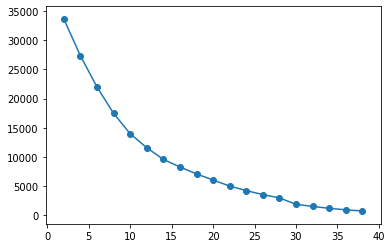

In [77]:
plt.plot(num_clusters, wss)
_ = plt.scatter(num_clusters, wss)

### Typically when using KMeans on text data the slope doesn't flatten out that much. However, from the scree plot above. There are two points I see where there is flattening. Next let's check the slope of the elbow/scree plot to if it is more prominent.

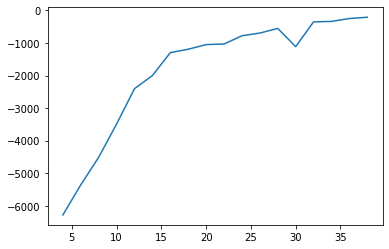

In [78]:
_ = plt.plot(num_clusters[1:], np.diff(wss))

### And it is. First break is between 15 and 20. Then there is another sharp breakat 20. I am going to pick 20 purely because it is a round number.
### The slope also seems to decrease a bit there according to the plot of the slope (np.diff()).

In [81]:
model = KMeans(n_clusters=20, random_state=42, n_jobs=-1)
model.fit(features)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=20, n_init=10, n_jobs=-1, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

### Predict on the features with the optimal K (20)

In [82]:
clusters = model.predict(features)

In [83]:
clusters

array([10, 18,  5, ..., 10, 10,  0], dtype=int32)

### One of the top purpose was to see the top words in each cluster.

In [84]:
# get top words for these clusters - first cluster 0
cluster0_docs = np.array(clean_texts)[clusters == 10]
cluster0_docs

array(['improper food storage',
       'unclean unmaintained improperly construct toilet facility',
       'mobile food facility unapproved operating condition', ...,
       'inadequate unsanitary refuse container area garbage service',
       'improper food storage',
       'inadequate dress room improper storage personal item'],
      dtype='<U65')

In [85]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [88]:
clean_text_array = np.array(clean_texts)
for i in range(20):
    cluster_docs = clean_text_array[clusters == i]
    wordcounts = nltk.FreqDist(nltk.tokenize.word_tokenize(' '.join(cluster_docs)))
    print('cluster', i + 1)
    print('number of datapoints in cluster:', np.sum(clusters == i))
    print('top 10 words and counts:')
    print(wordcounts.most_common()[:10])
    print('\na few random violations from the cluster:')
    print(just_violation[clusters == i].sample(1).values[0])
    print(just_violation[clusters == i].sample(1).values[0])
    print('\n')

cluster 1
number of datapoints in cluster: 11885
top 10 words and counts:
[('noviolation', 11885)]

a few random violations from the cluster:
noviolation
noviolation


cluster 2
number of datapoints in cluster: 2801
top 10 words and counts:
[('inadequate', 2801), ('facility', 2801), ('inaccessible', 2477), ('handwashing', 2477), ('warewashing', 324), ('equipment', 324)]

a few random violations from the cluster:
Inadequate and inaccessible handwashing facilities
Inadequate and inaccessible handwashing facilities


cluster 3
number of datapoints in cluster: 3849
top 10 words and counts:
[('risk', 3849), ('food', 3849), ('hold', 3849), ('temperature', 3849), ('moderate', 2373), ('high', 1476)]

a few random violations from the cluster:
High risk food holding temperature
Moderate risk food holding temperature


cluster 4
number of datapoints in cluster: 1152
top 10 words and counts:
[('unclean', 1152), ('unsanitary', 1152), ('food', 1152), ('contact', 1152), ('surface', 1152)]

a few rand

In [89]:
clean_text_array

array(['improper food storage', 'permit license inspection report post',
       'unapproved unmaintained equipment utensil', ...,
       'improper food storage',
       'inadequate dress room improper storage personal item',
       'noviolation'], dtype='<U65')

### I looked into removing common words such as 'health', 'inspection', 'clean', 'improper'. However, I decided not to include them in the final version since the corpus is fairly uniform. In fact there are only 66 unique items, hence my inference on the number of restaurnat inspectors.

In [90]:
pd.DataFrame(df_corpus['violation_description'].value_counts())

,violation_description
noviolation,11885
Unclean or degraded floors walls or ceilings,3230
Unapproved or unmaintained equipment or utensils,2682
Inadequately cleaned or sanitized food contact surfaces,2593
Inadequate and inaccessible handwashing facilities,2477
...,...
Discharge from employee nose mouth or eye,5
Noncompliance with Gulf Coast oyster regulation,4
Mobile food facility stored in unapproved location,4
Improperly displayed mobile food permit or signage,3


In [91]:
np.bincount(clusters)
# Finally a look at the bin and number of contents in each of 4 bins.

array([11885,  2801,  3849,  1152,  1826,  2682,  3230,  2442,  1804,
        1527,  5314,  2593,  1229,   708,  1060,   871,  1365,   825,
         734,   868])

### From the bin size it looks like using noviolation was the correct approach. This way all that was clustered in a single bin and that in my opinion did not effect the other bins. There is only one bin with double the amount of next top ones.Looks like this cluster has a lot of generic words. I think the business decision here is not to properly capture all the topics here but have an idea about its spread.

## Concat all cluster_labels into a single cluster

In [92]:
allClusters = np.array([])
for x in range(0, 10):
    myArray = np.array(clean_texts)[clusters == x]
    allClusters = np.concatenate([allClusters, myArray])

In [93]:
allClusters.shape

(33198,)

## Word Cloud

In [94]:
# Python program to convert a list to string 
# Function to convert   
def listToString(s):  
    # initialize an empty string 
    str1 = ""    
    # traverse in the string   
    for ele in s:  
        str1 += ele       
    # return string   
    return str1 

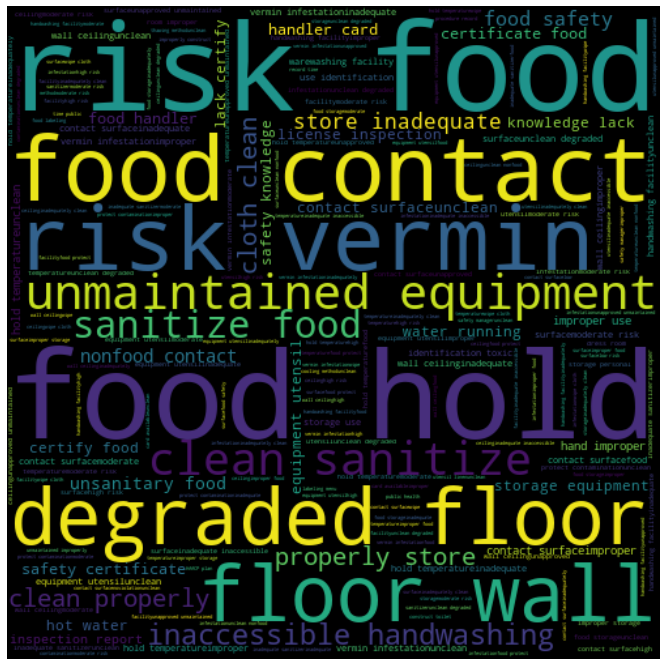

In [97]:
# Generate a word cloud image for cluster0_docs
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12, 12)) # size of the figure
wordcloud = WordCloud(width=500, height=500).generate(listToString(clean_texts)) #width and height changes the resolution

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
_ = plt.axis("off") #dont show the xand y axis by turning them off

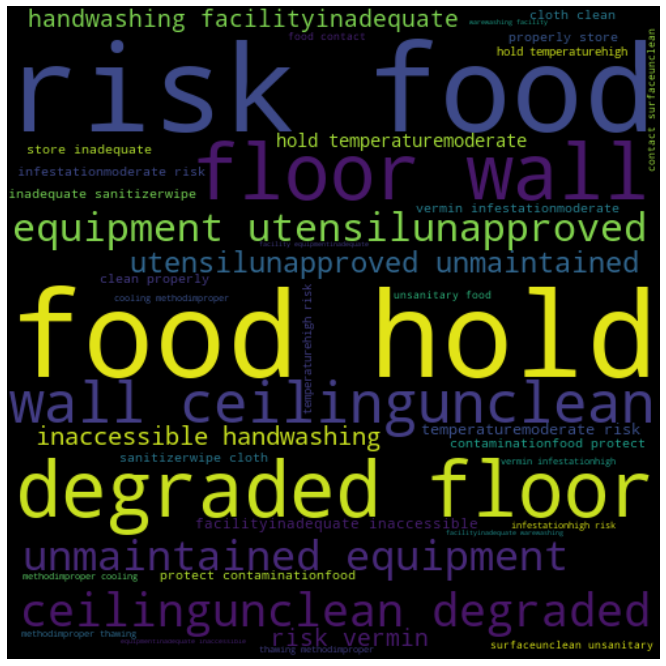

In [98]:
# Generate a word cloud image for allClusters
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12, 12)) # size of the figure
wordcloud = WordCloud(width=500, height=500).generate(listToString(allClusters)) #width and height changes the resolution

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
_ = plt.axis("off") #dont show the xand y axis by turning them off


## Bi-grams

In [116]:
v = CountVectorizer(ngram_range=(2, 2)) #count only ngrams in the range of 2 to 2

In [117]:
grams = v.fit_transform(allClusters) # use fit transform method to fit to our data

In [118]:
# about 5k 2-grams - 6 documents
grams.shape

(33198, 36)

In [119]:
# convert to array and flatten to avoid weird indexing
gram_sum = np.array(np.sum(grams, axis=0)).flatten()

#sum of all documents, all documents are collapsed to just one count

In [120]:
gram_sum.shape

(36,)

In [121]:
type(v.vocabulary_)   # dictionary of bigrams to index. Changed it to display type instead of contents for the pdf

dict

In [122]:
# argsort gets the indices sorted from least to greatest
# [::-1] is a fancy indexing trick to reverse the array
gram_dict = {i: v for v, i in v.vocabulary_.items()}  # dictionary of index: word - this is dictionary comprehension
top_grams = gram_sum.argsort()[::-1]  #start:stop:step .  step=-1 go backwards one. start blank means go over whole list. 

In [123]:
for i in top_grams[:10]:
    print('"' + gram_dict[i] + '" shows up', gram_sum[i], 'times')  # top 10 n grams

"moderate risk" shows up 4029 times
"risk food" shows up 3849 times
"hold temperature" shows up 3849 times
"food hold" shows up 3849 times
"floor wall" shows up 3230 times
"wall ceiling" shows up 3230 times
"degraded floor" shows up 3230 times
"unclean degraded" shows up 3230 times
"unmaintained equipment" shows up 2682 times
"unapproved unmaintained" shows up 2682 times


## Tri-grams

In [124]:
v = CountVectorizer(ngram_range=(3, 3)) #count only ngrams in the range of 2 to 2

In [125]:
grams = v.fit_transform(allClusters) # use fit transform method to fit to our data
gram_sum = np.array(np.sum(grams, axis=0)).flatten()

In [126]:
# argsort gets the indices sorted from least to greatest
# [::-1] is a fancy indexing trick to reverse the array
gram_dict = {i: v for v, i in v.vocabulary_.items()}  # dictionary of index: word - this is dictionary comprehension
top_grams = gram_sum.argsort()[::-1]  #start:stop:step .  step=-1 go backwards one. start blank means go over whole list. 

In [127]:
for i in top_grams[:10]:
    print('"' + gram_dict[i] + '" shows up', gram_sum[i], 'times')  # top 10 n grams

"risk food hold" shows up 3849 times
"food hold temperature" shows up 3849 times
"degraded floor wall" shows up 3230 times
"unclean degraded floor" shows up 3230 times
"floor wall ceiling" shows up 3230 times
"unmaintained equipment utensil" shows up 2682 times
"unapproved unmaintained equipment" shows up 2682 times
"inadequate inaccessible handwashing" shows up 2477 times
"inaccessible handwashing facility" shows up 2477 times
"risk vermin infestation" shows up 2442 times
